# GAN for TTS

We are making a generative adversarial network (GAN) for Text-to-Speech (TTS) model. The structure of a normal Deep Convolutional GAN (DCGAN) is as follows:

![alt_text](http://gluon.mxnet.io/_images/dcgan.png)

But we will be implementing it for Speech. Now we prefer to use CNN over RNN because it is much more easily trainable, and making the model is much more easy. Also recent models like wavenet which have outperformed aything else, have use dilated convolutional models.

The major bottle neck for using convolutions is that it requires a constant size of input and output, which is difficult to obtain on text based or audio based data.

To deal with this, in this notebook we will be padding the sequences to the maximum length. In future we will be building more complex R-CNN models, to deal with these kinds of issues.

In [3]:
import glob # file management
import pandas as pd # dataframe handling
import numpy as np # matrix math
import tensorflow as tf # ML
import scipy.io.wavfile as wvf # importing .wav files
import matplotlib.pyplot as plt # plotting of waveforms
%matplotlib inline
from six.moves import xrange # xrange to save the memory
import os # saving the models
import re # NLP
import nltk # NLP
import codecs # codec
from keras.preprocessing.sequence import pad_sequences # for padding of sequences to proper length

# importing the custom model
import model_AGAN as Agan

In [4]:
# getting the folders and making a dataframe of addresses
f_path = '~/Audio_Exps/VCTK-Corpus'
folders = glob.glob(f_path + '/wav48/*')
folder_text = glob.glob(f_path + '/txt/*')
info = pd.read_csv('~/Audio_Exps/VCTK-Corpus/info.csv')

In [5]:
# determining the different number of samples we have for different ID females
lens = []
addresses = []
for f in folders:
    files = glob.glob(f + '/*.wav')
    lens.append(len(files))
    addresses.append(files)
    
print('[*]Minimum number of files for any female is:',min(lens))

[*]Minimum number of files for any female is: 172


## Processing the text

The text will be our input to the generator model.

We are making a character driven model rather than a word-based one-hot-encoded model. The issue with latter is that ['How', 'are', 'you', '?'] is same as ['you', 'How', 'are', '?']. But now that we are using a char based system we will have inputs like:
##### (not actual input)

[ 0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 33, 46,  1, 27, 33, 32, 42, 33, 47, 32, 29, 53,  1, 29, 48,  1, 48, 36, 33,  1, 48, 46, 29, 37, 42,  1, 47, 48, 29, 48, 37, 43, 42,  5]

As we can see that some of the chars are repeating and we can also use its temporal data, i.e. the placement of different letters.

This adds up as another benifit of the model that it is now free of way the text is spoken, i.e. we can generate fine sounding gibirish just like done in the wavenet paper.

In [6]:
# Making the text data char based rather than word based
# Processing the text
files_text = glob.glob(folder_text[0] + '/*.txt')

# making the whole corpus
corpus = u""
for file_path in files_text:
    f = codecs.open(file_path, 'r', 'utf-8')
    corpus += f.read()

# converting to sentences and then into chars
corpus = corpus.split('\n')
sentences = []
chars = []
for s in corpus:
    temp = []
    for c in s:
        temp.append(c)
        chars.extend(c)
    sentences.append(temp)
        
# now making the char2id dictionary
chars = sorted(list(set(chars)))
print('[*]Total unique characters are:', len(chars))
char2id = dict((c,int(i+1)) for i,c in enumerate(chars))
# we are adding or increasing by 1 because, 0 is used for padding

[*]Total unique characters are: 54


In [7]:
# now we convert our text to vectors
maxlen_sent = max([len(s) for s in sentences])
print('[%]Sentence with largest characters is:', maxlen_sent)

data_gen = []
for s in sentences[:min(lens)]:
    temp = []
    for t in s:
        temp.append(char2id[t])
    data_gen.append(temp)

# now padding the sentenecs to max_len
data_gen = pad_sequences(data_gen)
print('[%]data_gen.shape', data_gen.shape)

[%]Sentence with largest characters is: 178
[%]data_gen.shape (172, 178)


## Loading the audio

These will be fed into our discriminator model. The discriminator will have to decide whether it's true or not.

In [8]:
# gettings ids for all the female audio
ids = []
for i, idx in enumerate(info['ID']):
    if info['GENDER'][i] == 'F':
        ids.append(idx)

# Making all the folders
# while we are using a sigle audio file, this is useless
# folders = [str(f_path + '/wav48/p{0}'.format(i)) for i in ids]

In [9]:
# For running a prototype, lets only take a few files, for running the whole model we will take all the files

# We will be taking only 1 speaker and use their audio for discrimination
total_audio = []
for f in addresses[:1]:
    temp = []
    for a in f[:min(lens)]:
        temp2 = []
        data = wvf.read(a)[1]
        for d in data:
            temp2.append(d)
        temp.append(temp2)
    total_audio.append(temp)

['W', 'e', ' ', 'a', 'l', 's', 'o', ' ', 'n', 'e', 'e', 'd', ' ', 'a', ' ', 's', 'm', 'a', 'l', 'l', ' ', 'p', 'l', 'a', 's', 't', 'i', 'c', ' ', 's', 'n', 'a', 'k', 'e', ' ', 'a', 'n', 'd', ' ', 'a', ' ', 'b', 'i', 'g', ' ', 't', 'o', 'y', ' ', 'f', 'r', 'o', 'g', ' ', 'f', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'k', 'i', 'd', 's', '.']


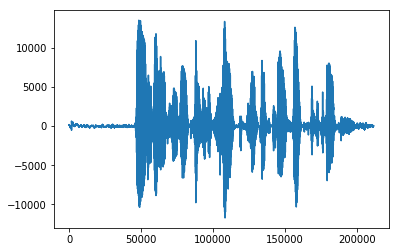

In [10]:
print(sentences[3])
plt.plot(total_audio[0][3])

In [11]:
# Padding the audio files with 0s too so that they can be fed into the convolutional models
maxlen_p = max([len(a) for a in total_audio[0]])
seq_len = maxlen_p # max(maxlen_p1, maxlen_p2, maxlen_p3)
print('Length of each sequence is:', seq_len)

Length of each sequence is: 630649


In [12]:
data_audio = []
for i in range(len(total_audio)):
    # the reason for using this maxlen is due to the limitations of convolution architecture
    # the architecture is explained below
    data_audio.append(pad_sequences(total_audio[i], maxlen = 630850))
data_audio = np.array(data_audio[0])
data_audio = np.reshape(data_audio, [-1, 630850, 1])
print('Shape of audio file:',data_audio.shape)

Shape of audio file: (172, 630850, 1)


## A Generative Adverserial Model 

Now we make a GAN which has 2 parts a generator part and a discriminator part.

We will be creating this new architecture, I need to make a custom sketch for it.

We will be using batch normalisation in generator model, you can [learn more about it](https://medium.com/deeper-learning/glossary-of-deep-learning-batch-normalisation-8266dcd2fa82). Basically it normalizes the input such that new_mean = 0.0 and new_std = 1.0 .

In [13]:
# Defining the params
session = tf.Session()
total_audio = data_audio
total_text = data_gen
seq_length = 630850
text_length = data_gen.shape[1]
n_epochs = 30
learning_rate = 0.002
d_step = 3
save_step = 10
verbose = True

In [16]:
# loading the model
agan = Agan.AGAN(session = session, total_audio = total_audio, total_text = data_gen, seq_length = seq_length,
            text_length = text_length, n_epochs = n_epochs, learning_rate = learning_rate, 
            d_step = d_step, save_step = save_step, verbose = verbose)
# building the model
agan.build_model()

[*]g1: Tensor("Reshape_6:0", shape=(?, 1380, 1), dtype=float32)
[*]g2: Tensor("Reshape_7:0", shape=(?, 17920, 1), dtype=float32)
[*]g3: Tensor("Reshape_8:0", shape=(?, 114688, 1), dtype=float32)
[*]g4: Tensor("Reshape_9:0", shape=(?, 630850, 1), dtype=float32)
Tensor("Reshape_9:0", shape=(?, 630850, 1), dtype=float32)
[*]d1: Tensor("add_19:0", shape=(?, 6309, 16), dtype=float32)
[*]d2: Tensor("add_20:0", shape=(?, 158, 32), dtype=float32)
[*]d3: Tensor("add_21:0", shape=(?, 8, 128), dtype=float32)
[*]d4: Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)
[*]d5: Tensor("add_23:0", shape=(?, 1), dtype=float32)
[!]Model Build, Ready for training...


In [15]:
agan.train()

KeyboardInterrupt: 